In [ ]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2023
### Student Name: Manish Adhikari
### Student ID: a1876371
### Comptetion Name: Animal Classification Competition
### Final Results:    - Top-1 Accuracy on test data: 94.85%
###                   - Top-3 Accuracy on test data: 97.34%
###                   - Top-5 Accuracy on test data: 98.28%

### ACC: 94.26% (testing_accuracy)       FLOPs: 0.61G


##################################################################################################################################

## Question 2: Animal classification (15 marks)

For this question, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals.

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories.

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.

The following changes could be considered:

1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others - please ask us on the Discussion Forums if you're not sure about an idea!

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

### Marking Rules:

We will mark this question based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark

**Acc_mark 10:**

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

**Efficiency mark 10:**

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

**Report mark 30:**

Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]



**SET-UP**

In [1]:
# DOWNLOADING THE FUNCTION TO COUNT THE FLOP
#The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py
#!rm -rf download

--2023-08-11 12:59:33--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=ckvsu9sghobksjleqjvo03h0p9; path=/plus; domain=.aarnet.edu.au;; Secure; SameSite=Lax at position 76.
Syntax error in Set-Cookie: oc_sessionPassphrase=9R63nKR%2BOmDvkmJyrlsk9oSa90DKyG25JSKYwVxCImp2te26d92gwgjyCZlU5IXbKc5R3hE6Uatt2s4INLunlnZ4E%2BBV5J0zi98Dsgm0jvbz8wGjtVAfsTLd6qN%2B8SQz; expires=Sat, 12-Aug-2023 12:59:34 GMT; Max-Age=86400; path=/plus;; Secure; SameSite=Lax at position 222.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2023-08-11 12:59:34 (1.01 GB/s) - ‘download’ saved [5201/5201]



In [2]:
# Importing libraries.

import os

import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim

import json



# LIBRARY FOR DATA VISUALIZATION
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

from FLOPs_counter import print_model_parm_flops


# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')



In [3]:
# Mounting G-Drive to get your dataset.
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/Colab Notebooks/trim 3/animal/dataset/dataset'
classes = os.listdir(data_dir)
classes.sort()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import json

translation_dir = '/content/drive/MyDrive/Colab Notebooks/trim 3/animal/'

# Load the class labels from the 'translation.json' file
translation_file = os.path.join(translation_dir, 'translation.json')
with open(translation_file, 'r') as f:
    class_label = json.load(f)

class_labels = {k: class_label[k] for k in sorted(class_label)}

### **BASELINE MODEL DATA PREPROCESSING**

In [5]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [6]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

# Get the label mapping (numerical label to folder name)
label_to_num1 = {class_idx: class_name for class_name, class_idx in dataset.class_to_idx.items()}
print('Label mapping (numerical label to folder name):')
print(label_to_num1)

Size of training dataset : 6270
Label mapping (numerical label to folder name):
{0: 'acinonyx-jubatus', 1: 'aethia-cristatella', 2: 'agalychnis-callidryas', 3: 'agkistrodon-contortrix', 4: 'ailuropoda-melanoleuca', 5: 'ailurus-fulgens', 6: 'alces-alces', 7: 'anas-platyrhynchos', 8: 'ankylosaurus-magniventris', 9: 'apis-mellifera', 10: 'aptenodytes-forsteri', 11: 'aquila-chrysaetos', 12: 'ara-macao', 13: 'architeuthis-dux', 14: 'ardea-herodias', 15: 'balaenoptera-musculus', 16: 'betta-splendens', 17: 'bison-bison', 18: 'bos-gaurus', 19: 'bos-taurus', 20: 'bradypus-variegatus', 21: 'branta-canadensis', 22: 'canis-lupus', 23: 'canis-lupus-familiaris', 24: 'carcharodon-carcharias', 25: 'cardinalis-cardinalis', 26: 'cathartes-aura', 27: 'centrochelys-sulcata', 28: 'centruroides-vittatus', 29: 'ceratitis-capitata', 30: 'ceratotherium-simum', 31: 'chelonia-mydas', 32: 'chrysemys-picta', 33: 'circus-hudsonius', 34: 'codium-fragile', 35: 'coelacanthiformes', 36: 'colaptes-auratus', 37: 'connoch

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 6270
    Root location: /content/drive/MyDrive/Colab Notebooks/trim 3/animal/dataset/dataset
    StandardTransform
Transform: Compose(
               Resize(size=112, interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(112, 112))
               ToTensor()
               Normalize(mean=0.488, std=0.2172)
           )

**DATA VISUALIZATION**

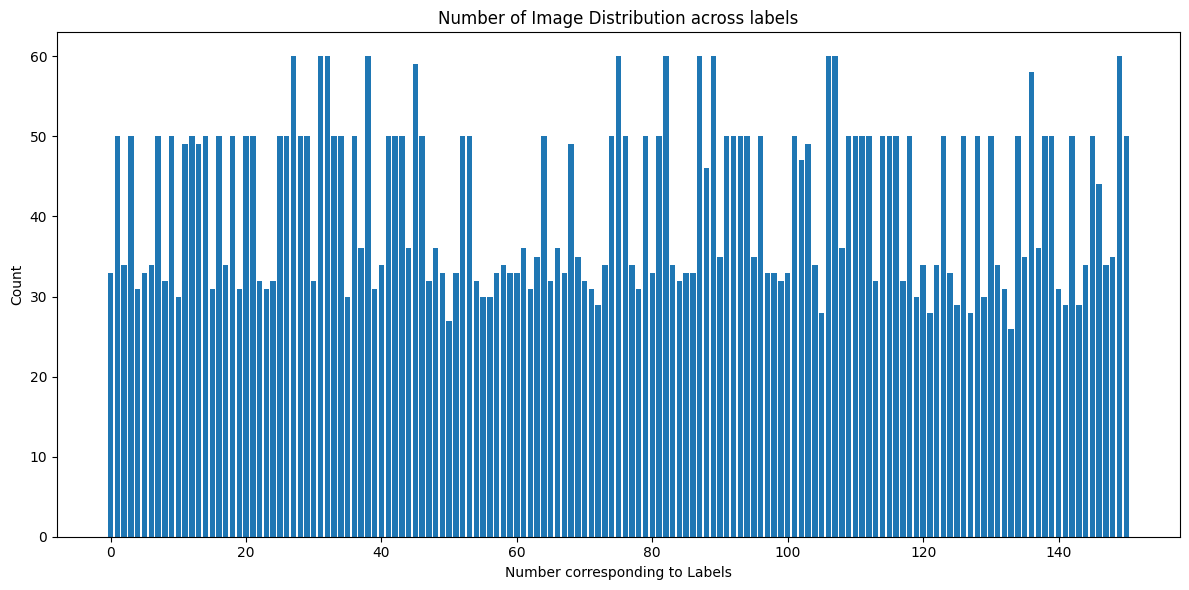

In [ ]:
# Get the dataset statistics
class_counts = dataset.targets
unique_labels, label_counts = np.unique(class_counts, return_counts=True)

# Create a bar graph
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, label_counts)

# Set labels and title
plt.xlabel('Number corresponding to Labels')
plt.ylabel('Count')
plt.title('Number of Image Distribution across labels')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 6270
    Root location: /content/drive/MyDrive/animal/dataset/dataset/
    StandardTransform
Transform: Compose(
               Resize(size=112, interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(112, 112))
               ToTensor()
               Normalize(mean=0.488, std=0.2172)
           )

**DATA VISUALIZATION**

In [ ]:
# Viewing one of images shape.
img, label = dataset[1300]
print(img.shape)


torch.Size([3, 112, 112])


In [ ]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  centruroides-vittatus (28)


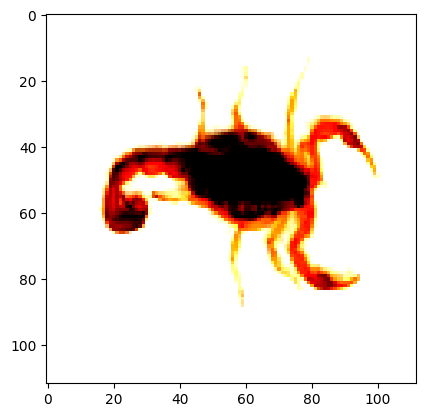

In [ ]:
show_image(*dataset[1200])

In [ ]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print(f"Training data size:{train_size}\n{'='*40}\nTesting data size:{test_size}\n{'='*40}\nValidation data size:{val_size}")

Training data size:5330
Testing data size:627
Validation data size:313


In [ ]:
# SETTING DATALOADER FOR EACH SETS OF DATA
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

tensor([ 80,  62,  75, 142, 134, 117, 121,  78,  71,  17,  89,  28,  11,  25,
         70,  80])


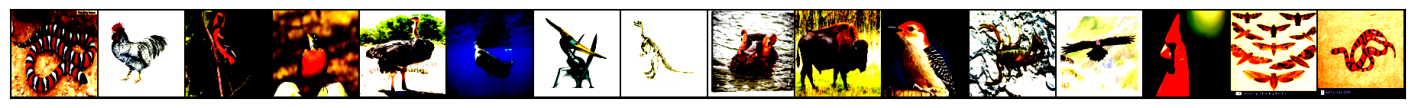

In [ ]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    print(labels)
    break

**GLOBAL FUNCTON DEFINITION'S**

In [8]:
# Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


In [10]:
class ImageClassificationBase(nn.Module):
  def __init__(self, use_focal_loss=False, gamma=None):
    super().__init__()
    self.use_focal_loss = use_focal_loss
    self.gamma = gamma

  def training_step(self, batch):
    images, labels = batch
    out = self(images)  # Generate predictions

    if self.use_focal_loss:
        loss = FocalLoss(gamma=self.gamma)  # Replace with your focal loss implementation
    else:
        loss = F.cross_entropy(out, labels)  # Calculate Cross-Entropy Loss

    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)  # Generate predictions

    if self.use_focal_loss:
        loss = FocalLoss(gamma=self.gamma)  # Replace with your focal loss implementation
    else:
        loss = F.cross_entropy(out, labels)  # Calculate Cross-Entropy Loss

    acc = accuracy(out, labels, (5))  # Calculate accuracy
    return {'val_loss': loss.item(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack([torch.tensor(loss) for loss in batch_losses]).mean()   # Convert to tensor before stacking
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
import matplotlib.pyplot as plt
# Functions for evaluation
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Functions for  PLOTTING LOSS AND ACCURRACY
def plot_accuracies_losses(history, capt: str):
    epochs = range(1, len(history) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(capt)

    # Plot accuracies
    axes[0].plot(epochs, [x['val_acc'] for x in history], '-x')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy vs. Epoch')
    axes[0].grid(True)

    # Plot losses
    axes[1].plot(epochs, [x.get('train_loss') for x in history], '-bx', label='Training')
    axes[1].plot(epochs, [x['val_loss'] for x in history], '-rx', label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].set_title('Loss vs. Epoch')
    axes[1].grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


In [13]:
def plot_multiple_optim_accuracies_losses(optimizer_history, capt: str):
  """
    Plot the accuracy and loss curves for multiple optimizers on the same subplots.

      Input:
            optimizer_history (dict): A dictionary containing optimizer histories withkeys 'val_acc', 'train_loss', and 'val_loss'.
            capt (str): The title for the entire plot.

      Returns:
            None.
  """
  epochs = range(1, len(next(iter(optimizer_history.values()))) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  fig.suptitle(capt)

  # Plot accuracies
  for optimizer_name, history in optimizer_history.items():
    axes[0].plot(epochs, [x['val_acc'] for x in history], label=optimizer_name)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy vs. Epoch')
    axes[0].legend()
    axes[0].grid(True)

  # Plot losses
  for optimizer_name, history in optimizer_history.items():
    axes[1].plot(epochs, [x.get('train_loss') for x in history], label=f'{optimizer_name} Training')
    axes[1].plot(epochs, [x['val_loss'] for x in history], label=f'{optimizer_name} Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].set_title('Loss vs. Epoch')
    axes[1].grid(True)

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()


# BASELINE CLASS DEFINITION

In [14]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
  def __init__(self, classes, focal_loss_func=False, gamma=2.0):
    super().__init__(focal_loss_func, gamma)
    self.num_classes=classes
    self.conv1=nn.Conv2d(3,64,5,1)
    self.conv2=nn.Conv2d(64,128,3,1)
    self.conv3=nn.Conv2d(128,128,3,1)
    self.conv4=nn.Conv2d(128,128,3,1)
    self.fc1=nn.Linear(128*5*5,self.num_classes)

  def forward(self,X):
    X=F.relu(self.conv1(X))
    X=F.max_pool2d(X,2,2)
    X=F.relu(self.conv2(X))
    X=F.max_pool2d(X,2,2)
    X=F.relu(self.conv3(X))
    X=F.max_pool2d(X,2,2)
    X=F.relu(self.conv4(X))
    X=F.max_pool2d(X,2,2)
    X=X.view(-1,128*5*5)
    X=self.fc1(X)

    return F.log_softmax(X, dim=1)

In [15]:
# Functions for training.
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        model.eval()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
input_size = 3*112*112
output_size = 151

## **TRAINING THE MODEL**

**Experiment with batch_size: [8,16,32]**

Batch Size: 8



  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.8424, val_loss: 4.6639, val_acc: 0.0781


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.3459, val_loss: 4.3860, val_acc: 0.1531


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.8669, val_loss: 4.1990, val_acc: 0.2719


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.4079, val_loss: 3.9617, val_acc: 0.2688


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.9233, val_loss: 3.9304, val_acc: 0.3375


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.5110, val_loss: 4.0466, val_acc: 0.3438


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.0966, val_loss: 4.4399, val_acc: 0.3313


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.7149, val_loss: 4.7772, val_acc: 0.3781


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.4200, val_loss: 5.0713, val_acc: 0.3375


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.0913, val_loss: 5.8157, val_acc: 0.3469


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.9102, val_loss: 5.5280, val_acc: 0.3594


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.7532, val_loss: 6.6297, val_acc: 0.3281


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6137, val_loss: 8.0856, val_acc: 0.3187


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4485, val_loss: 8.0242, val_acc: 0.3438


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4083, val_loss: 8.9945, val_acc: 0.2875


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.3792, val_loss: 9.7498, val_acc: 0.2969


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.3080, val_loss: 9.8058, val_acc: 0.3187


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.2596, val_loss: 10.5405, val_acc: 0.3375


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3285, val_loss: 11.1034, val_acc: 0.3219


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.2298, val_loss: 11.3916, val_acc: 0.3063
Testing model with 0.001
 {'val_loss': 11.108567237854004, 'val_acc': 0.3127637207508087}


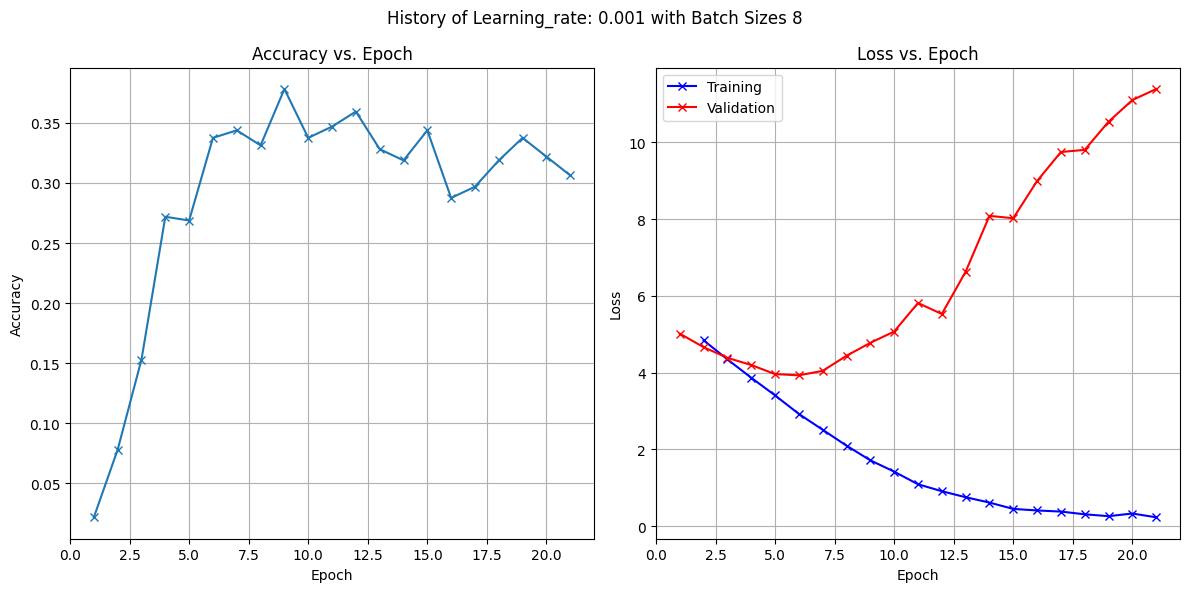

Batch Size: 16



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.8071, val_loss: 4.5824, val_acc: 0.0986


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.2694, val_loss: 4.3528, val_acc: 0.1729


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.8294, val_loss: 4.1956, val_acc: 0.2174


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.4518, val_loss: 4.1308, val_acc: 0.2580


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.0793, val_loss: 4.1018, val_acc: 0.2729


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.7122, val_loss: 4.3305, val_acc: 0.3128


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.3691, val_loss: 4.4191, val_acc: 0.2990


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.0292, val_loss: 4.6947, val_acc: 0.3403


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.7640, val_loss: 5.0197, val_acc: 0.3021


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.5136, val_loss: 5.6218, val_acc: 0.2972


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.2564, val_loss: 6.1596, val_acc: 0.3059


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.0448, val_loss: 6.3432, val_acc: 0.3097


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.9318, val_loss: 7.4256, val_acc: 0.3122


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.8042, val_loss: 8.0667, val_acc: 0.2910


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.7173, val_loss: 7.9721, val_acc: 0.2972


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5791, val_loss: 8.1410, val_acc: 0.3128


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4869, val_loss: 9.0371, val_acc: 0.3097


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4689, val_loss: 9.8570, val_acc: 0.3042


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3855, val_loss: 10.4223, val_acc: 0.2892


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.3851, val_loss: 10.9641, val_acc: 0.2948
Testing model with 0.001
 {'val_loss': 10.388788223266602, 'val_acc': 0.3098958432674408}


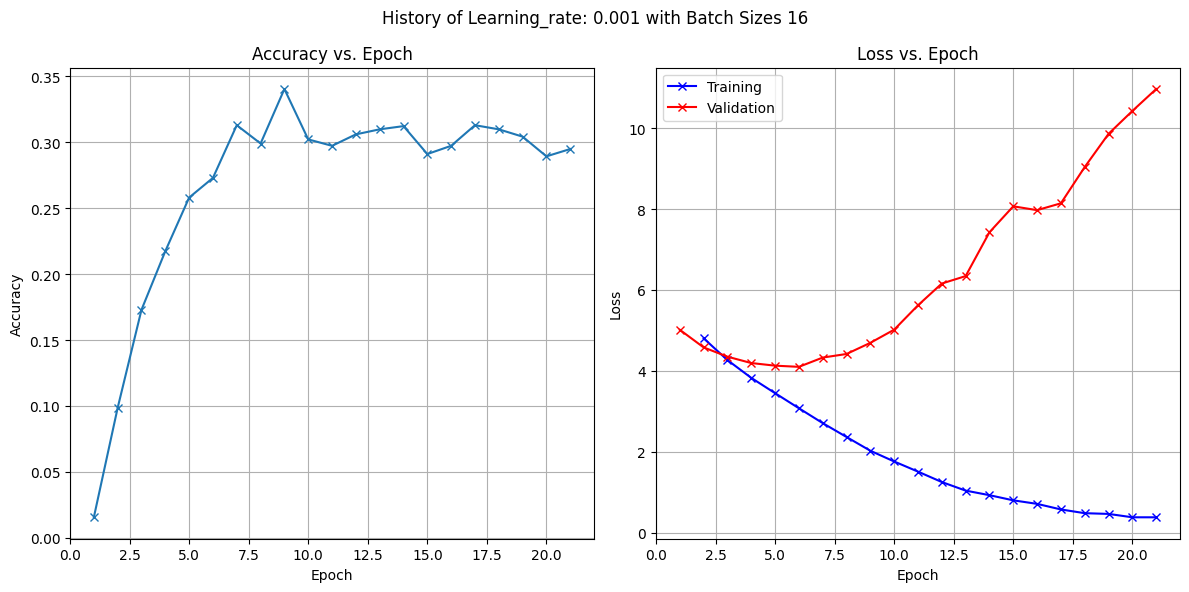

Batch Size: 32



  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7808, val_loss: 4.5319, val_acc: 0.1044


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.2411, val_loss: 4.2423, val_acc: 0.1794


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7792, val_loss: 4.0296, val_acc: 0.2508


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.3408, val_loss: 3.9823, val_acc: 0.2869


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.9265, val_loss: 4.0612, val_acc: 0.3252


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.4971, val_loss: 3.9937, val_acc: 0.3574


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.1399, val_loss: 4.1805, val_acc: 0.3279


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.7921, val_loss: 4.4336, val_acc: 0.3690


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.4874, val_loss: 5.0356, val_acc: 0.3346


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.2464, val_loss: 5.2260, val_acc: 0.3739


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.0708, val_loss: 5.3989, val_acc: 0.3364


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.8900, val_loss: 6.0639, val_acc: 0.3650


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6920, val_loss: 7.0205, val_acc: 0.3650


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5989, val_loss: 7.1650, val_acc: 0.3378


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5408, val_loss: 7.5588, val_acc: 0.3261


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4218, val_loss: 9.0588, val_acc: 0.3463


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.3986, val_loss: 9.4894, val_acc: 0.3065


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.3689, val_loss: 9.0069, val_acc: 0.3779


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3152, val_loss: 9.8592, val_acc: 0.3369


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.2616, val_loss: 10.9370, val_acc: 0.3204
Testing model with 0.001
 {'val_loss': 9.429292678833008, 'val_acc': 0.37828946113586426}


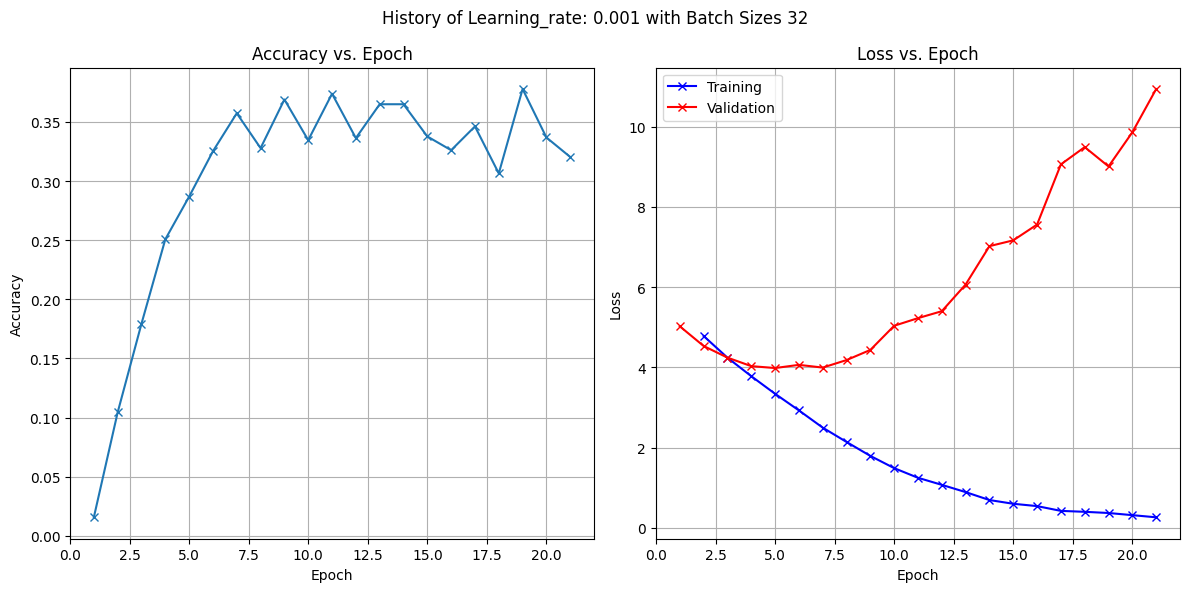

In [ ]:
# SETTING Hyperparamters
batch_sizes = [8,16, 32]
workers = 2  # 4/8
num_epochs = 20
lr = 0.001
device = get_default_device()
optimizer_func = optim.Adam  # You can change the optimizer if needed


input = torch.randn(1, 3, 112, 112)  # The input size should be the same as the size that you put into your model
num_classes = 151

for batch_size in batch_sizes:
    print(f"Batch Size: {batch_size}\n{'=' * 80}\n")

    # Data Loaders
    train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size, num_workers=workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size, num_workers=workers, pin_memory=True)

    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)
    test_loader = DeviceDataLoader(test_loader, device)

    # Create the model
    model = ConvolutionalNetwork(num_classes,False)

    if i == 0:
        # priting architecture Model and its FLOPs
        num_classes = 151
        print_model_parm_flops(model, input, detail=True)
        print(model)

    # Get the default device
    device = get_default_device()

    # Move the model and the dataloader to the appropriate device
    train_dl = DeviceDataLoader(train_loader, device)
    val_dl = DeviceDataLoader(val_loader, device)

    model = to_device(model, device)
    history = [evaluate(model, val_loader)]

    history += fit(num_epochs, lr, model, train_dl, val_dl, optimizer_func)
    print(f"Testing model with {lr}\n", evaluate(model, test_loader))

    plot_accuracies_losses(history,f"History of Learning_rate: {lr} with Batch Sizes {batch_size}")


**Experiment with Learning-rate and OPTIMIZER - ADAM AND SGD**

Learning Rate:0.0011

Optimizer:<class 'torch.optim.adam.Adam'>

 + Number of FLOPs: 0.70G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.8818, val_loss: 4.6818, val_acc: 0.0837


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.3688, val_loss: 4.3264, val_acc: 0.1899


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.8688, val_loss: 4.1058, val_acc: 0.2285


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.4771, val_loss: 4.0054, val_acc: 0.2566


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.0843, val_loss: 4.0877, val_acc: 0.2542


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.7465, val_loss: 4.2531, val_acc: 0.3003


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.4237, val_loss: 4.2522, val_acc: 0.3340


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.1034, val_loss: 4.3407, val_acc: 0.3396


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.8499, val_loss: 4.7403, val_acc: 0.3347


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.6015, val_loss: 4.9523, val_acc: 0.3122


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.3670, val_loss: 5.2750, val_acc: 0.3465


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.1658, val_loss: 5.9654, val_acc: 0.2667


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.0297, val_loss: 6.3408, val_acc: 0.3049


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.8528, val_loss: 6.9650, val_acc: 0.3153


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.7244, val_loss: 7.6549, val_acc: 0.3059


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5938, val_loss: 7.9181, val_acc: 0.2955


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5458, val_loss: 8.8914, val_acc: 0.2781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4716, val_loss: 9.4122, val_acc: 0.2917


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4380, val_loss: 9.8957, val_acc: 0.3135


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.3814, val_loss: 10.8652, val_acc: 0.2878
Testing model<class 'torch.optim.adam.Adam'> with 0.0011
 {'val_loss': 10.4041166305542, 'val_acc': 0.3114583492279053}
Optimizer:<class 'torch.optim.sgd.SGD'>

 + Number of FLOPs: 0.70G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0161, val_loss: 5.0155, val_acc: 0.0312


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 5.0115, val_loss: 5.0125, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 5.0067, val_loss: 5.0086, val_acc: 0.0312


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.9997, val_loss: 5.0021, val_acc: 0.0312


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9907, val_loss: 4.9958, val_acc: 0.0250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9802, val_loss: 4.9892, val_acc: 0.0219


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9695, val_loss: 4.9816, val_acc: 0.0250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.9573, val_loss: 4.9725, val_acc: 0.0406


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.9384, val_loss: 4.9559, val_acc: 0.0469


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.9139, val_loss: 4.9217, val_acc: 0.0531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 4.8739, val_loss: 4.8816, val_acc: 0.0625


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.8220, val_loss: 4.8141, val_acc: 0.0531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.7574, val_loss: 4.7537, val_acc: 0.0705


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.6867, val_loss: 4.6905, val_acc: 0.1024


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.5950, val_loss: 4.6286, val_acc: 0.1111


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.4713, val_loss: 4.5314, val_acc: 0.1236


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 4.3674, val_loss: 4.7154, val_acc: 0.0993


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 4.2629, val_loss: 4.5292, val_acc: 0.1385


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 4.1798, val_loss: 4.9179, val_acc: 0.1354


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 4.1141, val_loss: 4.4205, val_acc: 0.1674
Testing model<class 'torch.optim.sgd.SGD'> with 0.0011
 {'val_loss': 4.417459487915039, 'val_acc': 0.17499999701976776}


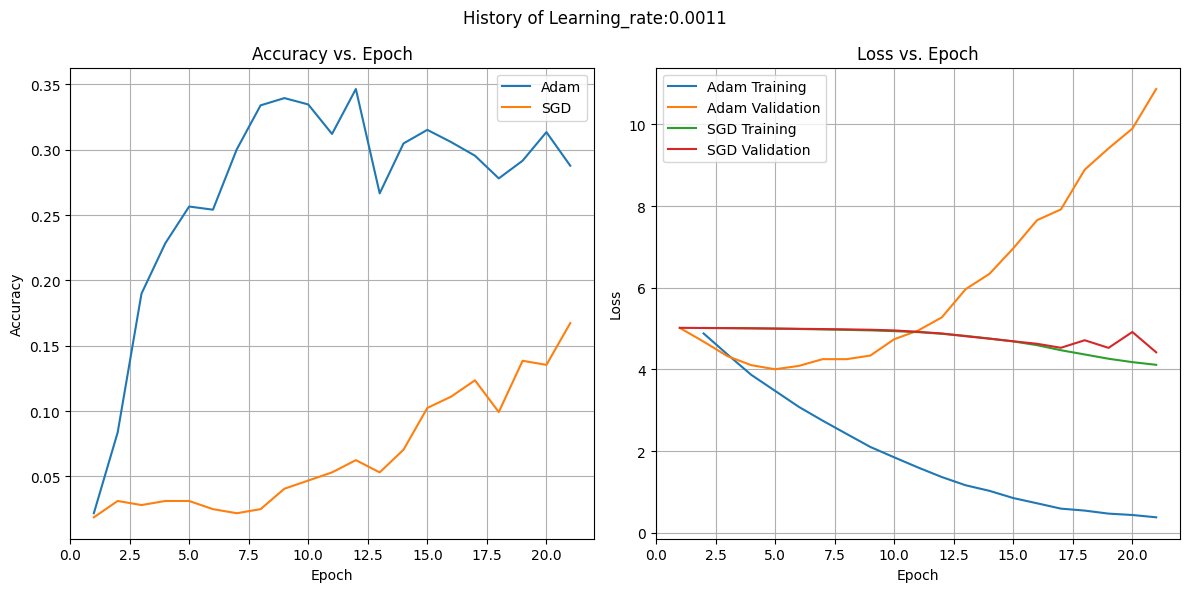

Learning Rate:0.0012000000000000001

Optimizer:<class 'torch.optim.adam.Adam'>



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.9273, val_loss: 4.6920, val_acc: 0.0500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.4036, val_loss: 4.3163, val_acc: 0.1524


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.9618, val_loss: 4.2271, val_acc: 0.2080


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.5493, val_loss: 4.0087, val_acc: 0.2576


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.1623, val_loss: 4.0632, val_acc: 0.2667


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.7778, val_loss: 4.2602, val_acc: 0.2878


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.4424, val_loss: 4.3093, val_acc: 0.2809


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.1289, val_loss: 4.5903, val_acc: 0.3146


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.8429, val_loss: 4.8787, val_acc: 0.2948


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.5215, val_loss: 5.7676, val_acc: 0.3184


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.2725, val_loss: 6.2469, val_acc: 0.2910


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.0906, val_loss: 6.2814, val_acc: 0.3465


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.9340, val_loss: 6.4860, val_acc: 0.3441


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.7369, val_loss: 7.4597, val_acc: 0.3035


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6465, val_loss: 8.0927, val_acc: 0.3003


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5788, val_loss: 8.5758, val_acc: 0.3128


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5250, val_loss: 9.3126, val_acc: 0.2997


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4558, val_loss: 9.7280, val_acc: 0.3035


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3931, val_loss: 11.5482, val_acc: 0.2847


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.3857, val_loss: 11.1219, val_acc: 0.3184
Testing model<class 'torch.optim.adam.Adam'> with 0.0012000000000000001
 {'val_loss': 10.176139831542969, 'val_acc': 0.3239583671092987}
Optimizer:<class 'torch.optim.sgd.SGD'>



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0170, val_loss: 5.0130, val_acc: 0.0375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 5.0135, val_loss: 5.0110, val_acc: 0.0344


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 5.0098, val_loss: 5.0075, val_acc: 0.0500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 5.0049, val_loss: 5.0023, val_acc: 0.0500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9984, val_loss: 4.9970, val_acc: 0.0500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9893, val_loss: 4.9881, val_acc: 0.0437


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9766, val_loss: 4.9808, val_acc: 0.0375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.9618, val_loss: 4.9724, val_acc: 0.0469


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.9430, val_loss: 4.9588, val_acc: 0.0531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.9120, val_loss: 4.9328, val_acc: 0.0531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 4.8635, val_loss: 4.8732, val_acc: 0.0719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.7739, val_loss: 4.7967, val_acc: 0.0813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.6507, val_loss: 4.6677, val_acc: 0.1031


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.5190, val_loss: 4.6482, val_acc: 0.0781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.4088, val_loss: 5.2345, val_acc: 0.1267


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.3171, val_loss: 4.5005, val_acc: 0.1767


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 4.2265, val_loss: 4.5519, val_acc: 0.1205


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 4.1466, val_loss: 4.5406, val_acc: 0.1847


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 4.0807, val_loss: 4.2988, val_acc: 0.1941


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 4.0140, val_loss: 4.3724, val_acc: 0.1510
Testing model<class 'torch.optim.sgd.SGD'> with 0.0012000000000000001
 {'val_loss': 4.392266273498535, 'val_acc': 0.18593750894069672}


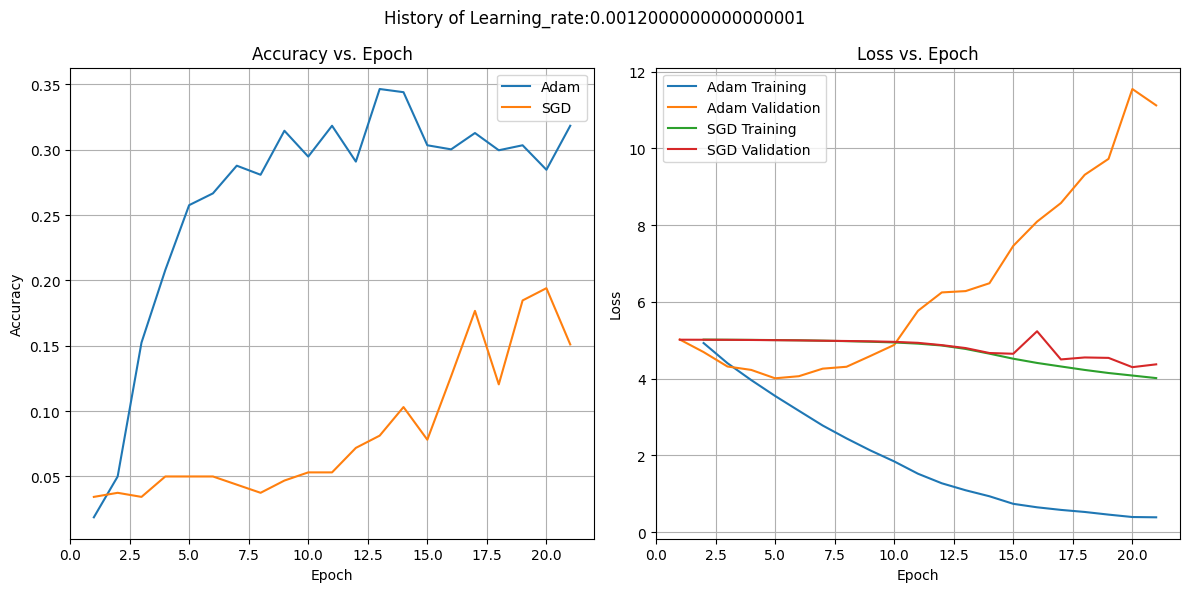

Learning Rate:0.0013

Optimizer:<class 'torch.optim.adam.Adam'>



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.8911, val_loss: 4.5998, val_acc: 0.0993


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.3558, val_loss: 4.3045, val_acc: 0.1830


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.9100, val_loss: 4.1501, val_acc: 0.2604


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.5137, val_loss: 3.9398, val_acc: 0.3208


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.1807, val_loss: 4.1284, val_acc: 0.2840


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.9000, val_loss: 4.0662, val_acc: 0.3122


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.6267, val_loss: 4.4119, val_acc: 0.3302


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.3689, val_loss: 4.3903, val_acc: 0.3010


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.1553, val_loss: 4.3994, val_acc: 0.3253


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.9130, val_loss: 4.8138, val_acc: 0.3354


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.7079, val_loss: 5.0787, val_acc: 0.2854


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.5097, val_loss: 5.3758, val_acc: 0.3236


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.3610, val_loss: 5.8194, val_acc: 0.3292


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.2030, val_loss: 6.1958, val_acc: 0.3160


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.0385, val_loss: 6.5242, val_acc: 0.3333


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.9299, val_loss: 7.3932, val_acc: 0.3097


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.8360, val_loss: 8.2485, val_acc: 0.3010


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.7479, val_loss: 8.0302, val_acc: 0.3035


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6431, val_loss: 8.6057, val_acc: 0.3090


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.5913, val_loss: 9.7712, val_acc: 0.2924
Testing model<class 'torch.optim.adam.Adam'> with 0.0013
 {'val_loss': 9.506895065307617, 'val_acc': 0.3005208671092987}
Optimizer:<class 'torch.optim.sgd.SGD'>



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0155, val_loss: 5.0100, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 5.0079, val_loss: 5.0043, val_acc: 0.0250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 5.0000, val_loss: 4.9953, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.9883, val_loss: 4.9852, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9734, val_loss: 4.9731, val_acc: 0.0094


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9552, val_loss: 4.9527, val_acc: 0.0219


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9260, val_loss: 4.9259, val_acc: 0.0375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.8802, val_loss: 4.8694, val_acc: 0.0625


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.8173, val_loss: 4.8156, val_acc: 0.0688


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.7312, val_loss: 4.7102, val_acc: 0.0938


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 4.6084, val_loss: 4.5974, val_acc: 0.1125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.4589, val_loss: 4.6034, val_acc: 0.1024


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.3344, val_loss: 4.5785, val_acc: 0.1337


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.2311, val_loss: 4.7191, val_acc: 0.1229


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.1437, val_loss: 4.4272, val_acc: 0.1562


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.0617, val_loss: 4.3467, val_acc: 0.1573


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 3.9928, val_loss: 4.2398, val_acc: 0.1823


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 3.9163, val_loss: 4.4583, val_acc: 0.1667


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 3.8635, val_loss: 4.2413, val_acc: 0.2080


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 3.7871, val_loss: 4.4968, val_acc: 0.1979
Testing model<class 'torch.optim.sgd.SGD'> with 0.0013
 {'val_loss': 4.500535488128662, 'val_acc': 0.20989584922790527}


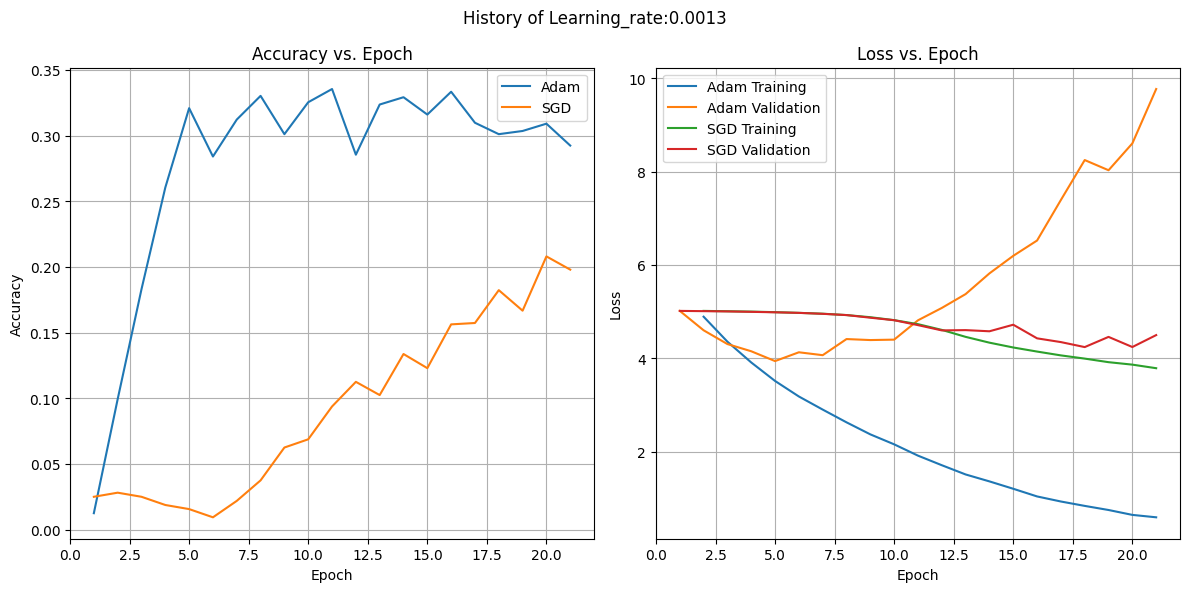

Learning Rate:0.0014

Optimizer:<class 'torch.optim.adam.Adam'>



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.9152, val_loss: 4.7532, val_acc: 0.0743


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.4477, val_loss: 4.3919, val_acc: 0.1462


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.0370, val_loss: 4.2554, val_acc: 0.2073


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.6090, val_loss: 4.3949, val_acc: 0.2191


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.2225, val_loss: 4.2285, val_acc: 0.2510


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.8497, val_loss: 4.4274, val_acc: 0.2927


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.4939, val_loss: 4.7530, val_acc: 0.2597


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.1645, val_loss: 4.9650, val_acc: 0.2840


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.8731, val_loss: 5.6018, val_acc: 0.2528


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.6173, val_loss: 5.6347, val_acc: 0.2684


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.4270, val_loss: 6.6799, val_acc: 0.2622


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.1998, val_loss: 7.1647, val_acc: 0.2260


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.0723, val_loss: 7.6965, val_acc: 0.2347


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.8702, val_loss: 8.4352, val_acc: 0.2628


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.7550, val_loss: 8.4130, val_acc: 0.2590


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6888, val_loss: 10.0634, val_acc: 0.2590


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5881, val_loss: 10.8435, val_acc: 0.2323


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.5194, val_loss: 10.8033, val_acc: 0.2566


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4635, val_loss: 11.6244, val_acc: 0.2424


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4182, val_loss: 12.9166, val_acc: 0.2292
Testing model<class 'torch.optim.adam.Adam'> with 0.0014
 {'val_loss': 12.223942756652832, 'val_acc': 0.2578125}
Optimizer:<class 'torch.optim.sgd.SGD'>



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0178, val_loss: 5.0154, val_acc: 0.0312


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 5.0137, val_loss: 5.0126, val_acc: 0.0437


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 5.0093, val_loss: 5.0087, val_acc: 0.0469


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 5.0034, val_loss: 5.0036, val_acc: 0.0375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9956, val_loss: 4.9959, val_acc: 0.0500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9839, val_loss: 4.9891, val_acc: 0.0375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9723, val_loss: 4.9803, val_acc: 0.0437


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.9584, val_loss: 4.9663, val_acc: 0.0563


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.9334, val_loss: 4.9410, val_acc: 0.0469


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.8989, val_loss: 4.9115, val_acc: 0.0406


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 4.8511, val_loss: 4.8743, val_acc: 0.0625


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.7931, val_loss: 4.8033, val_acc: 0.0806


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.7130, val_loss: 4.7221, val_acc: 0.0767


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.5791, val_loss: 4.6719, val_acc: 0.0844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.4078, val_loss: 4.5435, val_acc: 0.0892


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.2824, val_loss: 4.5668, val_acc: 0.1424


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 4.1842, val_loss: 4.3508, val_acc: 0.1510


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 4.1107, val_loss: 4.4760, val_acc: 0.1816


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 4.0296, val_loss: 4.4391, val_acc: 0.1604


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 3.9639, val_loss: 4.7140, val_acc: 0.1385
Testing model<class 'torch.optim.sgd.SGD'> with 0.0014
 {'val_loss': 4.678340435028076, 'val_acc': 0.17864583432674408}


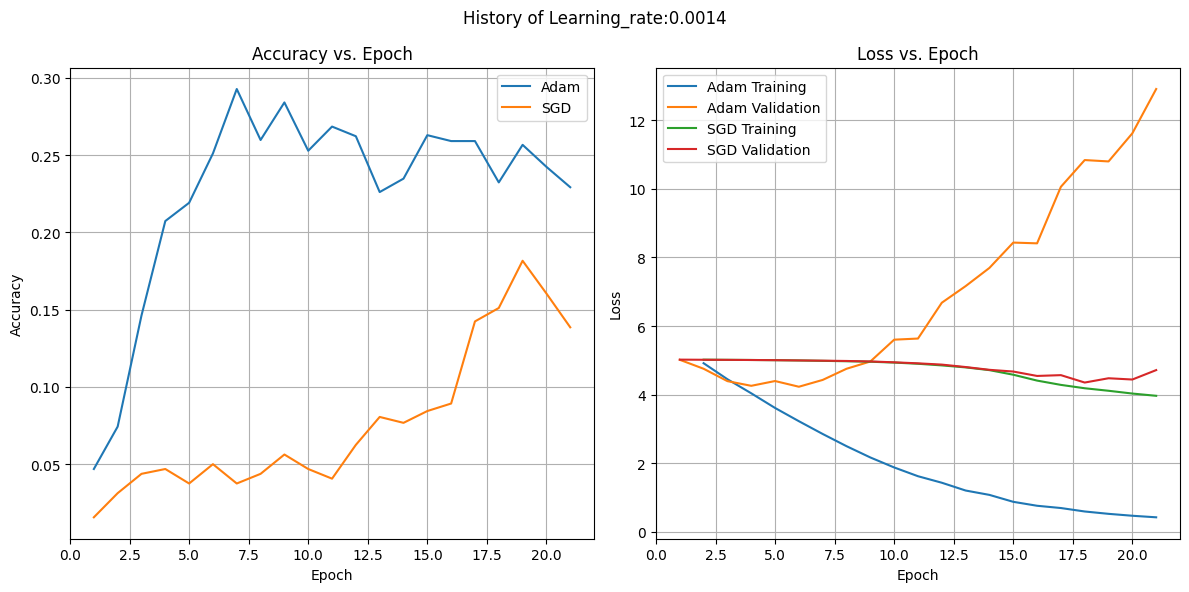

In [ ]:
# SETTING DATALOADER FOR EACH SETS OF DATA
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

input = torch.randn(batch_size, 3, 112, 112) # The input size should be the same as the size that you put into your model
num_classes = 151

# Metrics holder for plotting
best_valid_acc_sgd = []
best_valid_acc_adam = []
epoch_last_val_acc_sgd = []
epoch_last_val_acc_adam = []
test_acc_sgd = []
test_acc_adam = []

learning_rates =  [0.001+i/10000 for i in range(1,5,1)]
# List of optimizer classes from PyTorch
optimizer_classes = [optim.Adam, optim.SGD]


for i,lr in enumerate(learning_rates):
  print(f"Learning Rate:{lr}\n{'='*80}\n")

  optimizer_history = {}
  for optimizer_func in optimizer_classes:
    print(f"Optimizer:{optimizer_func}\n{'='*80}\n")
    #Create the model
    model = ConvolutionalNetwork(num_classes)

    if i == 0:
      # Model print
      num_classes = 151
      print_model_parm_flops(model, input, detail=True)
      print(model)

    # Get the default device
    device = get_default_device()

    # Move the model and the dataloader to the appropriate device
    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)
    test_loader = DeviceDataLoader(test_loader, device)


    model = to_device(model, device)
    history=[evaluate(model, val_loader)]

    num_epochs = 20

    history+= fit(num_epochs, lr, model, train_loader, val_loader, optimizer_func)\

    # =========================================================================
    val_acc = history[-1]['val_acc']
    test_acc_lr = evaluate(model, test_loader)

    best_val_acc = history[0]['val_acc']
    # Update best validation accuracy
    for epoch_result in history:
      val_acc = epoch_result['val_acc']
      best_val_acc = max(best_val_acc, val_acc)


    if optimizer_func.__name__ == 'Adam':
      best_valid_acc_adam.append(best_val_acc)
      epoch_last_val_acc_adam.append(val_acc)
      test_acc_adam.append(test_acc_lr['val_acc'])
    else:
      best_valid_acc_sgd.append(best_val_acc)
      epoch_last_val_acc_sgd.append(val_acc)
      test_acc_sgd.append(test_acc_lr['val_acc'])

    optimizer_history[optimizer_func.__name__] = history
    print(f"Testing model{optimizer_func} with {lr}\n",test_acc_lr)

  plot_multiple_optim_accuracies_losses(optimizer_history,f"History of Learning_rate:{lr}")


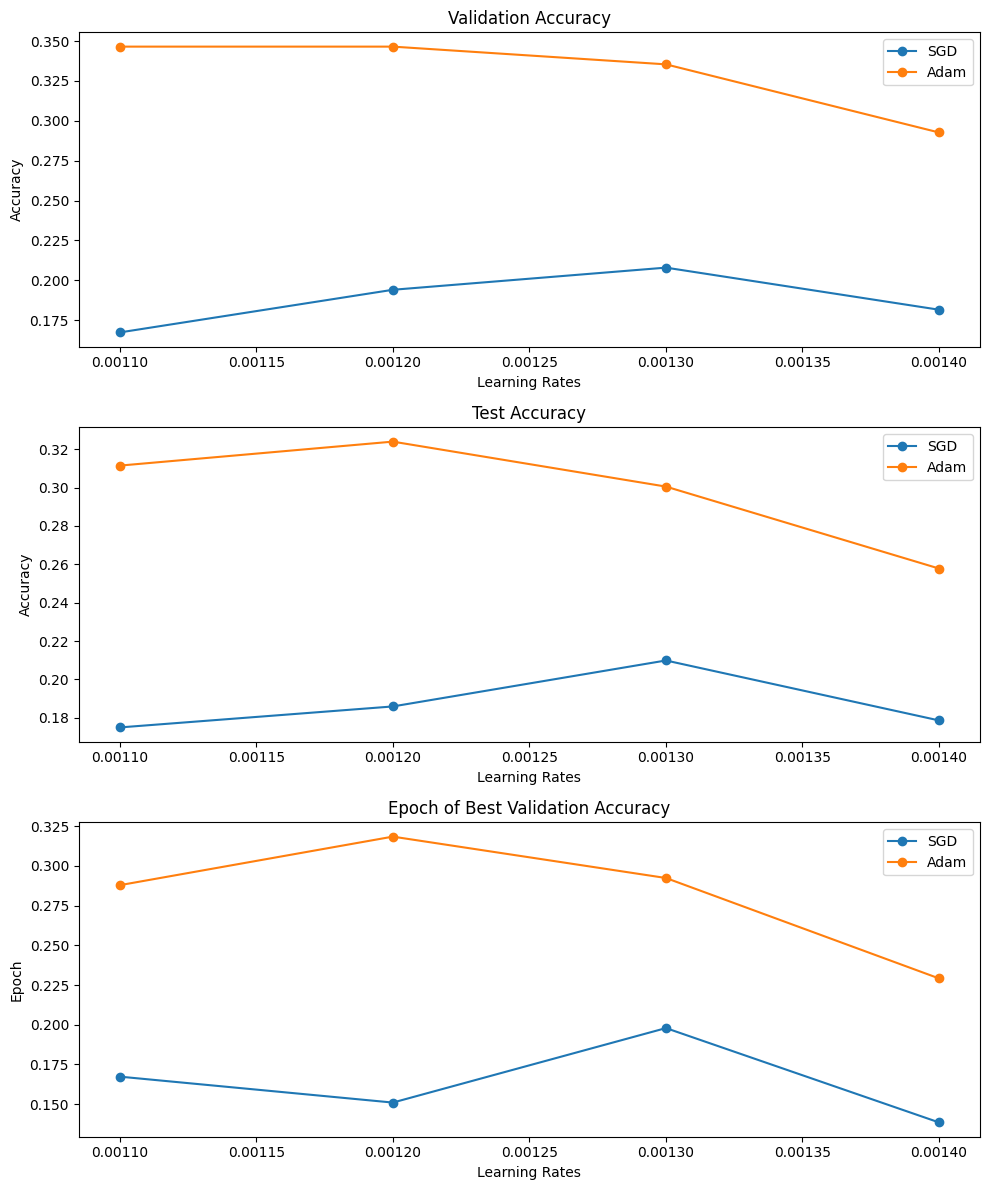

In [ ]:

# Data copied from above result for better comparision of optimizer - Adam and SGD performance for different learning rates

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot validation accuracy
axs[0].plot(learning_rates, best_valid_acc_sgd, label='SGD', marker='o')
axs[0].plot(learning_rates, best_valid_acc_adam, label='Adam', marker='o')
axs[0].set_title('Validation Accuracy')
axs[0].set_xlabel('Learning Rates')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot test accuracy
axs[1].plot(learning_rates, test_acc_sgd, label='SGD', marker='o')
axs[1].plot(learning_rates, test_acc_adam, label='Adam', marker='o')
axs[1].set_title('Test Accuracy')
axs[1].set_xlabel('Learning Rates')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot epoch at which best validation accuracy was achieved
axs[2].plot(learning_rates, epoch_last_val_acc_sgd, label='SGD', marker='o')
axs[2].plot(learning_rates, epoch_last_val_acc_adam, label='Adam', marker='o')
axs[2].set_title('Epoch of Best Validation Accuracy')
axs[2].set_xlabel('Learning Rates')
axs[2].set_ylabel('Epoch')
axs[2].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Experiment with LOSS FUNCTION - CROSS ENTROPY AND FOCAL LOSS with optimizers**

I tried to implement it but couldn't make it work. Eventually left trying.

##  Train_ transform dataset modified version

Code to compute std and mean of the data by iterating over it

In [23]:
# #  Check if a GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load the dataset and create train, val, and test loaders
# data_dir = '/content/drive/MyDrive/Colab Notebooks/trim 3/animal/dataset/dataset/'
# classes = os.listdir(data_dir)
# classes.sort()


# translation_dir = '/content/drive/MyDrive/Colab Notebooks/trim 3/animal/'
# translation_file = os.path.join(translation_dir, 'translation.json')
# with open(translation_file, 'r') as f:
#     class_labels = json.load(f)

# label_to_folder = {i: (folder_name, class_labels[folder_name]) for i, folder_name in enumerate(classes)}
# folder_to_label = {folder_name: i for i, folder_name in enumerate(classes)}

# #  the transformation without normalization
# transform = transforms.Compose([
#     transforms.Resize(112),
#     transforms.ToTensor(),
# ])


# dataset = ImageFolder(data_dir, transform=train_transform)

# # Creating a DataLoader to iterate over the dataset
# dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# # Calculate the mean and standard deviation of the dataset
# mean = torch.zeros(3).to(device)  # Assuming your images have 3 channels (RGB)
# std = torch.zeros(3).to(device)

# num_samples = 0

# for inputs, _ in tqdm(dataloader):
#     inputs = inputs.to(device)  # Move data to the GPU
#     batch_size = inputs.size(0)
#     inputs = inputs.view(batch_size, inputs.size(1), -1)
#     mean += inputs.mean(2).sum(0)
#     std += inputs.std(2).sum(0)
#     num_samples += batch_size

# mean /= num_samples
# std /= num_samples

# print("Calculated mean:", mean)
# print("Calculated std:", std)


# mean and std computed from above code copied to save time while re runnig code
std = [0.8862, 0.8722, 0.8863]
mean = [ 0.1131,  0.1113, -0.1463]

Using computed mean and std to transform the data

In [24]:

# Performing Image Transformations - the train_transform with additional data augmentation
train_transform = transforms.Compose([
    transforms.Resize(112),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
    transforms.RandomRotation(20),  # Randomly rotate images by up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate images
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# Create the ImageFolder dataset using the class_labels as the list of class labels
dataset_mod = ImageFolder(data_dir, transform=train_transform)#, target_transform=lambda x: label_to_folder[os.path.basename(os.path.dirname(x))])

# Checking the dataset training size.
print('Size of training dataset :', len(dataset_mod))

# Get the label mapping (numerical label to folder name)
label_to_num1 = {class_idx: class_name for class_name, class_idx in dataset_mod.class_to_idx.items()}

Size of training dataset : 6270


In [25]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
# torch.manual_seed(10)
val_size = len(dataset_mod)//20
test_size = len(dataset_mod)//10
train_size = len(dataset_mod) - val_size - test_size
# Random Splitting.
train_ds_mod, val_ds_mod, test_ds_mod = random_split(dataset_mod, [train_size, val_size, test_size])


# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#=================================================================================================================================
#                                                             HYPERPARAMETERS
#=================================================================================================================================
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

batch_size = 16 # SMLLAER DATASET - 8 TO 32
workers = 16 # chnage to 4 or 8
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#=================================================================================================================================

train_loader_mod = DataLoader(train_ds_mod, batch_size, shuffle=True, num_workers= workers, pin_memory=True) # NUMBER OF WORKERS = 4/8
val_loader_mod = DataLoader(val_ds_mod, batch_size, num_workers=workers, pin_memory=True)
test_loader_mod = DataLoader(test_ds_mod, batch_size, num_workers=workers, pin_memory=True)

Training Baseline model with optimizer Adam and SGD on the above transformed dataset

Optimizer:<class 'torch.optim.adam.Adam'>

 + Number of FLOPs: 0.69G
ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0091, val_loss: 5.0139, val_acc: 0.0312


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.9351, val_loss: 4.8963, val_acc: 0.0312


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.8221, val_loss: 4.8157, val_acc: 0.0531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.6488, val_loss: 4.6736, val_acc: 0.0969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.4340, val_loss: 4.5610, val_acc: 0.1375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.2686, val_loss: 4.4325, val_acc: 0.1406


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.1094, val_loss: 4.3808, val_acc: 0.1750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.9823, val_loss: 4.2646, val_acc: 0.1868


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.8846, val_loss: 4.2105, val_acc: 0.1844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.7995, val_loss: 4.2881, val_acc: 0.1938


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.7190, val_loss: 4.2066, val_acc: 0.1813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.6439, val_loss: 4.1738, val_acc: 0.2118


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 3.6070, val_loss: 4.1854, val_acc: 0.2344


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 3.5539, val_loss: 4.1840, val_acc: 0.2212


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 3.5309, val_loss: 4.1356, val_acc: 0.2604


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 3.4632, val_loss: 4.1274, val_acc: 0.2385


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 3.4118, val_loss: 4.0336, val_acc: 0.2681


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 3.3825, val_loss: 4.0400, val_acc: 0.2736


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 3.3397, val_loss: 4.2593, val_acc: 0.2431


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 3.2993, val_loss: 4.0627, val_acc: 0.2438
Testing model<class 'torch.optim.adam.Adam'> with 0.001
 {'val_loss': 3.8701395988464355, 'val_acc': 0.29114586114883423}


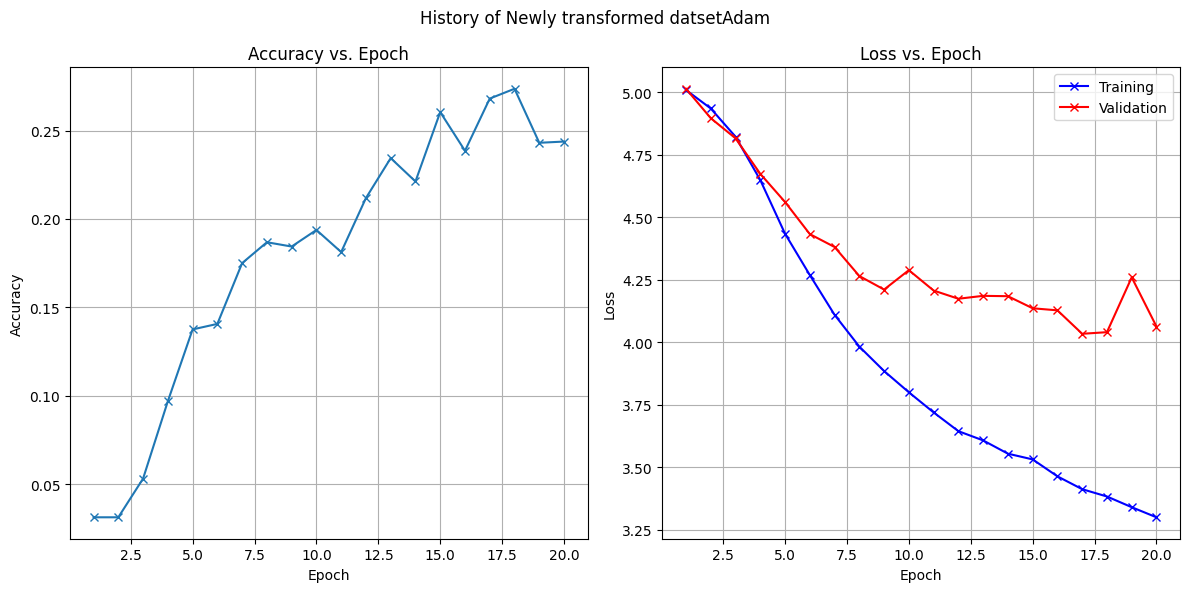

Optimizer:<class 'torch.optim.sgd.SGD'>



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0171, val_loss: 5.0155, val_acc: 0.0250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 5.0165, val_loss: 5.0152, val_acc: 0.0312


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 5.0156, val_loss: 5.0151, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 5.0147, val_loss: 5.0151, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 5.0139, val_loss: 5.0153, val_acc: 0.0125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 5.0128, val_loss: 5.0148, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 5.0113, val_loss: 5.0148, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 5.0098, val_loss: 5.0137, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 5.0078, val_loss: 5.0136, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 5.0053, val_loss: 5.0127, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 5.0017, val_loss: 5.0144, val_acc: 0.0125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.9977, val_loss: 5.0129, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.9937, val_loss: 5.0141, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.9914, val_loss: 5.0173, val_acc: 0.0125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.9884, val_loss: 5.0169, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.9861, val_loss: 5.0167, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 4.9855, val_loss: 5.0194, val_acc: 0.0125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 4.9847, val_loss: 5.0210, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 4.9837, val_loss: 5.0210, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 4.9833, val_loss: 5.0172, val_acc: 0.0188
Testing model<class 'torch.optim.sgd.SGD'> with 0.001
 {'val_loss': 5.016941070556641, 'val_acc': 0.015625}


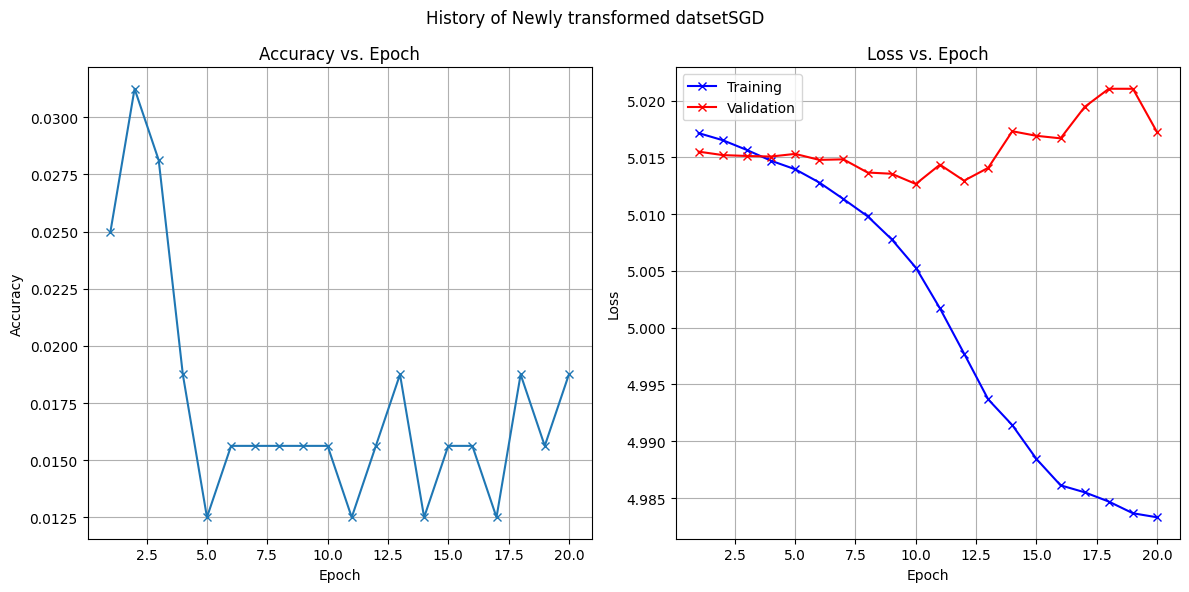

In [ ]:

input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model

# Get the network and its FLOPs
num_classes = 151
num_epochs = 20
lr = 0.001

# List of optimizer classes from PyTorch
optimizer_classes = [optim.Adam, optim.SGD]


for i,optimizer_func in enumerate(optimizer_classes):
  print(f"Optimizer:{optimizer_func}\n{'='*80}\n")
  #Create the model
  model = ConvolutionalNetwork(num_classes)

  if i == 0:
    # Model print
    num_classes = 151
    print_model_parm_flops(model, input, detail=True)
    print(model)

  # Get the default device
  device = get_default_device()

  # Move the model and the dataloader to the appropriate device
  train_dl = DeviceDataLoader(train_loader_mod, device)
  val_dl = DeviceDataLoader(val_loader_mod, device)
  test_dl = DeviceDataLoader(test_loader_mod, device)

  model = to_device(model, device)
  history=[]

  history+= fit(num_epochs, lr, model, train_dl, val_dl, optimizer_func)
  print(f"Testing model{optimizer_func} with {lr}\n",evaluate(model, test_dl))

  plot_accuracies_losses(history,f"History of Newly transformed datset{optimizer_func.__name__}")

## **CUSTOM MODEL**
(change in Architecture)

l1 REGULARIZATION implemented fit function

In [42]:

from torch.optim.lr_scheduler import ReduceLROnPlateau
def fit_custom(epochs, lr, model, train_loader, val_loader, lambda_l1=0.01, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs) # Forward pass
            loss = model.training_step(batch)  # Calculate the original loss
            l1_regularization = torch.tensor(0.0, device=inputs.device)  # Initialize L1 regularization term
            for param in model.parameters():
                l1_regularization += torch.norm(param, p=1)  # Calculate L1 norm of parameters
            loss += lambda_l1 * l1_regularization  # Add L1 regularization term to the loss
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
        # Validation phase
        model.eval()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        # Learning rate scheduler step based on validation performance
        scheduler.step(result['val_acc'])  # Adjust learning rate

    return history


Custom CNN model (Wider model)

In [43]:
import torch.nn as nn
class ConvolutionalNetwork_Wider(ImageClassificationBase):
  def __init__(self, classes):
    super().__init__()
    self.num_classes = classes
    self.conv1 = nn.Conv2d(3, 128, 5, 1)  # Increased channels
    self.conv2 = nn.Conv2d(128, 256, 3, 1)  # Increased channels

    self.dropout = nn.Dropout(0.5)

    self.conv3 = nn.Conv2d(256, 256, 3, 1)  # Increased channels
    self.conv4 = nn.Conv2d(256, 256, 3, 1)  # Increased channels

    # Update Batch Normalization to match the number of channels
    self.bn4 = nn.BatchNorm2d(256)  # Batch Normalization after the fourth convolution
    self.fc1 = nn.Linear(256 * 24 * 24, 512)  # Increased channels

    self.dropout = nn.Dropout(0.2)  # Dropout layer with dropout probability of 0.5

    self.fc2 = nn.Linear(512, self.num_classes)  # Increased channels


  def forward(self, X):
    # print("Input shape:", X.shape)
    X = self.conv1(X)
    X = F.relu(X)
    # print("Input shape:COnV1,RELU", X.shape)
    X = self.conv2(X)
    X = F.relu(X)
    # print("Input shape:COnV2,RELU", X.shape)

    X = F.max_pool2d(X, 2, 2)
    # print("Input shape:MAXPOOL", X.shape)
    X = self.dropout(X)  # Applying dropout before the final fully connected layer
    # print("Input shape:DROPUTOUT", X.shape)
    X = self.conv3(X)
    X = F.relu(X)
    # print("Input shape:COnV3,RELU", X.shape)
    X = self.conv4(X)
    X = F.relu(X)
    # print("Input shape:COnV4,RELU", X.shape)
    X = self.bn4(X)  # Batch Normalization after the fourth convolution
    # print("Input shape:BATCH", X.shape)
    X = F.max_pool2d(X, 2, 2)
    # print("Input shapeMAXPOL:", X.shape)
    X = X.view(-1, 256*24*24)
    X = self.fc1(X)
    X = F.relu(X)
    X = self.dropout(X)
    X = self.fc2(X)
    return F.log_softmax(X, dim=1)


Training custom model with baseline or provided transformed data

In [45]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
# torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])


# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#=================================================================================================================================
#                                                             HYPERPARAMETERS
#=================================================================================================================================
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

batch_size = 32 # SMLLAER DATASET - 8 TO 32
workers = 32 # chnage to 4 or 8
learning_rates =0.001
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#=================================================================================================================================

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers= workers, pin_memory=True) # NUMBER OF WORKERS = 4/8
val_loader = DataLoader(val_ds, batch_size, num_workers=workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=workers, pin_memory=True)

num_classes = 151
model_mod = ConvolutionalNetwork_Wider(num_classes)

# Get the default device
device = get_default_device()

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
to_device(model_mod, device)
model_mod = to_device(model_mod, device)


history=[]
#model.cuda()
num_epochs = 10
opt_function = torch.optim.Adam


history+= fit_custom(num_epochs, learning_rates, model_mod, train_dl, val_dl,0.001, opt_function)
print(evaluate(model_mod, test_dl))

100%|██████████| 167/167 [00:49<00:00,  3.35it/s]


Epoch [0], train_loss: 60.9923, val_loss: 5.6146, val_acc: 0.0415


100%|██████████| 167/167 [00:49<00:00,  3.39it/s]


Epoch [1], train_loss: 23.1887, val_loss: 11.0980, val_acc: 0.0361


100%|██████████| 167/167 [00:49<00:00,  3.36it/s]


Epoch [2], train_loss: 26.3061, val_loss: 5.0838, val_acc: 0.0392


100%|██████████| 167/167 [00:49<00:00,  3.37it/s]


Epoch [3], train_loss: 19.2002, val_loss: 5.4034, val_acc: 0.0549


100%|██████████| 167/167 [00:49<00:00,  3.37it/s]


Epoch [4], train_loss: 21.5885, val_loss: 4.8220, val_acc: 0.1187


100%|██████████| 167/167 [00:49<00:00,  3.35it/s]


Epoch [5], train_loss: 22.3385, val_loss: 4.8736, val_acc: 0.0625


100%|██████████| 167/167 [00:49<00:00,  3.36it/s]


Epoch [6], train_loss: 20.5983, val_loss: 4.6285, val_acc: 0.1361


100%|██████████| 167/167 [00:49<00:00,  3.36it/s]


Epoch [7], train_loss: 19.7884, val_loss: 4.6174, val_acc: 0.1183


100%|██████████| 167/167 [00:49<00:00,  3.35it/s]


Epoch [8], train_loss: 20.5545, val_loss: 4.5866, val_acc: 0.1066


100%|██████████| 167/167 [00:49<00:00,  3.35it/s]


Epoch [9], train_loss: 19.3586, val_loss: 4.5832, val_acc: 0.1214
{'val_loss': 4.692190647125244, 'val_acc': 0.11200658231973648}


NameError: ignored

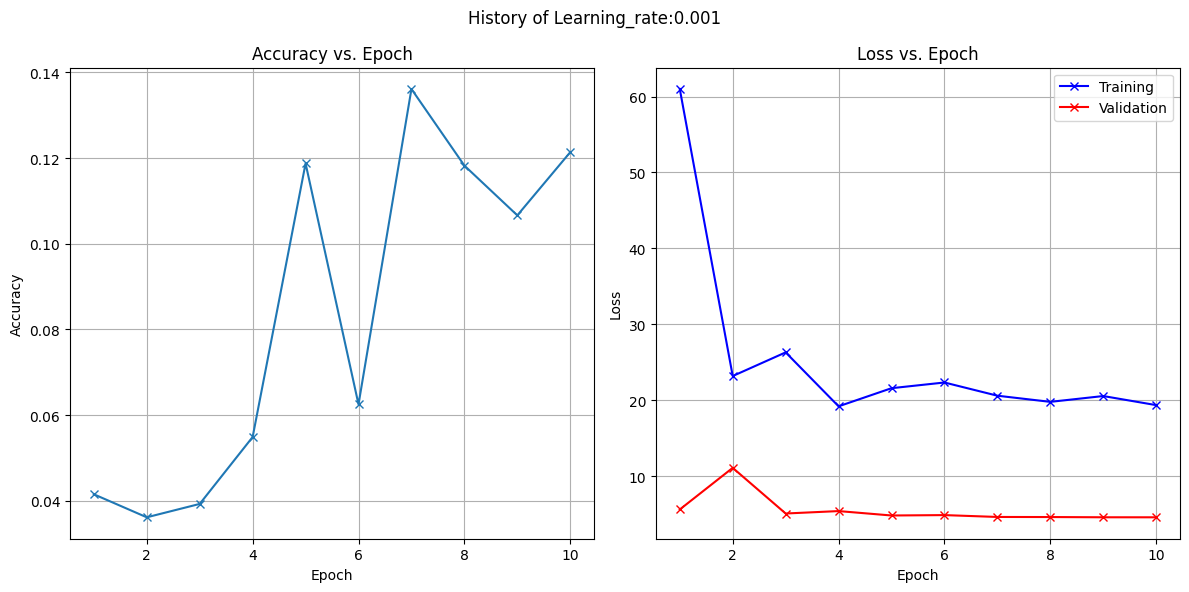

In [46]:

plot_accuracies_losses(history,f"History of Learning_rate:{learning_rates}")

Training custom model with different version of transformed data than that of baseline

In [47]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
# torch.manual_seed(10)
val_size = len(dataset_mod)//20
test_size = len(dataset_mod)//10
train_size = len(dataset_mod) - val_size - test_size
# Random Splitting.
train_ds_mod, val_ds_mod, test_ds_mod = random_split(dataset_mod, [train_size, val_size, test_size])


# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#=================================================================================================================================
#                                                             HYPERPARAMETERS
#=================================================================================================================================
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

batch_size = 16 # SMLLAER DATASET - 8 TO 32
workers = 16 # chnage to 4 or 8
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#=================================================================================================================================

train_loader_mod = DataLoader(train_ds_mod, batch_size, shuffle=True, num_workers= workers, pin_memory=True) # NUMBER OF WORKERS = 4/8
val_loader_mod = DataLoader(val_ds_mod, batch_size, num_workers=workers, pin_memory=True)
test_loader_mod = DataLoader(test_ds_mod, batch_size, num_workers=workers, pin_memory=True)
learning_rates =  0.0012 # lr = 0.001

num_classes = 151
model_mod = ConvolutionalNetwork_Wider(num_classes)


# Get the default device
device = get_default_device()

train_dl_mod = DeviceDataLoader(train_loader_mod, device)
val_dl_mod = DeviceDataLoader(val_loader_mod, device)
test_dl_mod = DeviceDataLoader(test_loader_mod, device)
to_device(model_mod, device)
model_mod = to_device(model_mod, device)


history=[]
#model.cuda()
num_epochs = 25
opt_function = torch.optim.Adam


history+= fit_custom(num_epochs, learning_rates, model_mod, train_dl_mod, val_dl_mod,0.001, opt_function)
print(evaluate(model_mod, test_dl_mod))
plot_accuracies_losses(history,f"History of Learning_rate:{learning_rates}")

100%|██████████| 334/334 [00:55<00:00,  6.06it/s]


Epoch [0], train_loss: 47.7435, val_loss: 5.4105, val_acc: 0.0250


100%|██████████| 334/334 [00:54<00:00,  6.11it/s]


Epoch [1], train_loss: 19.1830, val_loss: 5.1739, val_acc: 0.0344


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Epoch [2], train_loss: 27.5322, val_loss: 6.0143, val_acc: 0.0219


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Epoch [3], train_loss: 26.1491, val_loss: 8.6337, val_acc: 0.0188


100%|██████████| 334/334 [00:55<00:00,  6.06it/s]


Epoch [4], train_loss: 23.1445, val_loss: 5.6744, val_acc: 0.0493


100%|██████████| 334/334 [00:55<00:00,  6.06it/s]


Epoch [5], train_loss: 23.9503, val_loss: 6.8515, val_acc: 0.0312


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Epoch [6], train_loss: 23.2815, val_loss: 5.6290, val_acc: 0.0368


100%|██████████| 334/334 [00:54<00:00,  6.07it/s]


Epoch [7], train_loss: 23.4167, val_loss: 5.5330, val_acc: 0.0156


100%|██████████| 334/334 [00:55<00:00,  6.06it/s]


Epoch [8], train_loss: 20.8834, val_loss: 4.8866, val_acc: 0.0431
Epoch 00009: reducing learning rate of group 0 to 6.0000e-04.


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Epoch [9], train_loss: 12.1415, val_loss: 4.8917, val_acc: 0.0399


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Epoch [10], train_loss: 11.4974, val_loss: 4.8671, val_acc: 0.0462


100%|██████████| 334/334 [00:55<00:00,  6.06it/s]


Epoch [11], train_loss: 11.0464, val_loss: 4.7893, val_acc: 0.0437


100%|██████████| 334/334 [00:55<00:00,  6.06it/s]


Epoch [12], train_loss: 10.7091, val_loss: 4.6835, val_acc: 0.0618


100%|██████████| 334/334 [00:55<00:00,  6.06it/s]


Epoch [13], train_loss: 10.4882, val_loss: 4.6764, val_acc: 0.0688


 23%|██▎       | 78/334 [00:13<00:45,  5.66it/s]


KeyboardInterrupt: ignored

# **Transfer learning**

After researching alot and experimenting with Efficientnet,Resnet,Densenet and Mobilenet for small epochs(i.e, 3)(not included in this implementation), I made a decision to use Mobilenet v2 and Efficientnet b4 for 20 epochs to decide which method should i use for Final model.

In [17]:

#Install with pip install efficientnet_pytorch and load a pretrained EfficientNet with:
!pip install efficientnet_pytorch

In [18]:
# Importing the necessary libraries
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import copy

# Define the models to experiment with
from efficientnet_pytorch import EfficientNet

In [19]:
def count_model_params(model, input_tensor):
    total_params = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += torch.prod(torch.tensor(param.size()))  # Count weights
        if 'bias' in name:
            total_params += torch.tensor(param.size(0))  # Count biases

    return total_params.item()


# Transfer Learning mobilenet v2 and efficientnet:

In [20]:
# downloading the dependencies
!pip install efficientnet-pytorch
!pip install torchvision


In [21]:
from tqdm import tqdm
from FLOPs_counter import print_model_parm_flops
from tqdm import tqdm

from tqdm import tqdm
import copy
import torch
import torch.optim as optim

class ModelTrainer:
  def __init__(self, model, criterion, optimizer, scheduler, device):
    self.model = model.to(device)
    self.criterion = criterion.to(device)
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.device = device
    self.train_history = {'loss': [], 'acc': []}
    self.val_history = {'loss': [], 'acc': []}

  def compute_metrics(self, data_loader,desp ="Processing"):
    self.model.eval()
    running_loss = 0.0
    correct_5 = 0
    total = 0

    # Create a progress bar for the loader
    data_bar = tqdm(data_loader, desc=desp)

    with torch.no_grad():
      for inputs, labels in data_bar:
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)

        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # Calculate top-5 accuracy
        correct_5 += (predicted == labels.view(-1, 1)).sum()

        running_loss += loss.item()
        # Update progress bar with current loss
        data_bar.set_postfix({"Loss": running_loss / total,"Acc":correct_5.item() / total })

    return running_loss / total, correct_5 / total

  def train(self, train_loader, val_loader, num_epochs=25):
    best_model_wts = copy.deepcopy(self.model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Set the model to training mode
        self.model.train()
        running_loss = 0.0

        # Create a progress bar for training
        train_bar = tqdm(train_loader, desc="Training")

        for inputs, labels in train_bar:
          inputs = inputs.to(self.device)
          labels = labels.to(self.device)

          # Zero the gradients
          self.optimizer.zero_grad()

          with torch.set_grad_enabled(True):
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()

          batch_size = inputs.size(0)
          running_loss += loss.item()

          # Update progress bar with current loss
          train_bar.set_postfix({"Loss": running_loss / ((train_bar.n + 1) * batch_size)})

        epoch_loss = running_loss / len(train_loader)
        self.train_history['loss'].append(epoch_loss)
        # print(f'Train Loss: {epoch_loss:.4f}')

        # Validation phase
        self.model.eval()
        epoch_loss, val_acc = self.compute_metrics( val_loader,"Validation")

        self.val_history['loss'].append(epoch_loss)
        self.val_history['acc'].append(val_acc)
        # Adjust learning rate with scheduler
        self.scheduler.step()

    return self.model, (self.train_history, self.val_history)

  def test(self, test_loader):
    self.model.eval()
    running_loss = 0.0

    # Create a progress bar for testing
    test_loss, test_acc = self.compute_metrics( test_loader,"Testing")
    print('Test Loss: {:.4f}'.format(test_loss),'Test ACC: {:.4f}'.format(test_acc))



In [26]:
import torch
import torchvision
from efficientnet_pytorch import EfficientNet
from torchvision.models import mobilenet_v2
import os
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from tqdm import tqdm
from FLOPs_counter import print_model_parm_flops

# Set hyperparameters
num_epochs = 20
num_classes = 151
dropout_prob = 0.4
batch_size = 32


train_loader_mod = DataLoader(train_ds_mod, batch_size, shuffle=True, num_workers= workers, pin_memory=True) # NUMBER OF WORKERS = 4/8
val_loader_mod = DataLoader(val_ds_mod, batch_size, num_workers=16, pin_memory=True)
test_loader_mod = DataLoader(test_ds_mod, batch_size, num_workers=16, pin_memory=True)

# Get the default device
device = get_default_device()

# Move the model and the dataloader to the appropriate device
train_dl = DeviceDataLoader(train_loader_mod, device)
val_dl = DeviceDataLoader(val_loader_mod, device)
test_dl = DeviceDataLoader(test_loader_mod, device)

Training Mobilenetv2 and Efficientnet b4

In [49]:

# Models to experiment with
models_to_experiment = {
    "MobileNetV2": mobilenet_v2(pretrained=True),
    "EfficientNet-b4": EfficientNet.from_pretrained('efficientnet-b4')
}

for model_name, model in models_to_experiment.items():
  if model_name == "EfficientNet-b4":
    # Modify the EfficientNet-b4 classifier
    model._fc = nn.Sequential(
        nn.Linear(model._fc.in_features, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )
    optimizer = optim.Adam(model._fc.parameters(), lr=0.001)

  elif model_name == "MobileNetV2":
    # Modify the MobileNetV2 classifier
    model.classifier[1] = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )
    optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
  # Freeze the parameters of the pre-trained layers
    for param in model.parameters():
        param.requires_grad = False

    # Enable gradient calculation and optimization for the newly added layers
    if model_name == "EfficientNet-b4":
        for param in model._fc.parameters():
            param.requires_grad = True
    elif model_name == "MobileNetV2":
        for param in model.classifier[1].parameters():
            param.requires_grad = True

  # Move the model to the appropriate device
  model = model.to(device)

  # Define your loss function and optimizer here
  # Loss criterion and optimizer
  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.Adam(model._fc.parameters(), lr=0.001)

  # Learning rate scheduler
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

  # Train the model & Validation
  print(f"Training {model_name}\n{'=' * 80}")
  trainer = ModelTrainer(model, criterion, optimizer, exp_lr_scheduler, device)
  trained_model, (train_history,val_history) = trainer.train(train_dl, val_dl, num_epochs)

  # Evaluate the model on the test set
  trainer.test(test_dl)



Loaded pretrained weights for efficientnet-b4
Training MobileNetV2
Epoch 0/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s, Loss=0.111, Acc=0.39]


Epoch 1/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s, Loss=0.0927, Acc=0.55]


Epoch 2/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s, Loss=0.0894, Acc=0.534]


Epoch 3/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.12it/s, Loss=0.0823, Acc=0.645]


Epoch 4/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s, Loss=0.0824, Acc=0.613]


Epoch 5/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s, Loss=0.0786, Acc=0.581]


Epoch 6/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.37it/s, Loss=0.0776, Acc=0.607]


Epoch 7/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s, Loss=0.0786, Acc=0.623]


Epoch 8/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s, Loss=0.0699, Acc=0.671]


Epoch 9/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.03it/s, Loss=0.0749, Acc=0.658]


Epoch 10/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s, Loss=0.0689, Acc=0.655]


Epoch 11/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s, Loss=0.0708, Acc=0.655]


Epoch 12/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s, Loss=0.0716, Acc=0.639]


Epoch 13/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s, Loss=0.0747, Acc=0.629]


Epoch 14/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.10it/s, Loss=0.0728, Acc=0.633]


Epoch 15/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s, Loss=0.0735, Acc=0.69]


Epoch 16/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Loss=0.0677, Acc=0.7]


Epoch 17/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.99it/s, Loss=0.0683, Acc=0.7]


Epoch 18/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s, Loss=0.0686, Acc=0.681]


Epoch 19/19
----------


Testing: 100%|██████████| 20/20 [00:01<00:00, 13.74it/s, Loss=0.0673, Acc=0.691]


Test Loss: 0.0673 Test ACC: 0.6906
Training EfficientNet-b4
Epoch 0/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s, Loss=0.129, Acc=0.415]


Epoch 1/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.00it/s, Loss=0.109, Acc=0.425]


Epoch 2/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.94it/s, Loss=0.105, Acc=0.473]


Epoch 3/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s, Loss=0.103, Acc=0.492]


Epoch 4/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s, Loss=0.0996, Acc=0.482]


Epoch 5/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.10it/s, Loss=0.0976, Acc=0.473]


Epoch 6/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.16it/s, Loss=0.0976, Acc=0.476]


Epoch 7/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s, Loss=0.0965, Acc=0.562]


Epoch 8/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s, Loss=0.0967, Acc=0.514]


Epoch 9/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.12it/s, Loss=0.0969, Acc=0.47]


Epoch 10/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s, Loss=0.0952, Acc=0.479]


Epoch 11/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.10it/s, Loss=0.097, Acc=0.546]


Epoch 12/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s, Loss=0.0955, Acc=0.498]


Epoch 13/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s, Loss=0.0986, Acc=0.524]


Epoch 14/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.05it/s, Loss=0.0965, Acc=0.524]


Epoch 15/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s, Loss=0.0903, Acc=0.505]


Epoch 16/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.22it/s, Loss=0.0942, Acc=0.534]


Epoch 17/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.20it/s, Loss=0.0906, Acc=0.54]


Epoch 18/19
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  7.05it/s, Loss=0.0916, Acc=0.575]


Epoch 19/19
----------


Testing: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s, Loss=0.0906, Acc=0.574]

Test Loss: 0.0906 Test ACC: 0.5742


In [32]:

def plot_curves(train_history, val_history):
    plt.figure(figsize=(12, 6))
    epochs = range(1, len(train_history['loss']) + 1)

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_history['loss'], '-x', label='Train')
    plt.plot(epochs, val_history['loss'], '-x', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.grid(True)

    # Plot validation accuracy
    val_acc_list = [tensor.cpu().numpy() for tensor in val_history['acc']]
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_acc_list, '-x', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs. Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Loss vs Epoch and Val_acc vs Epoch curve for Efficient b4

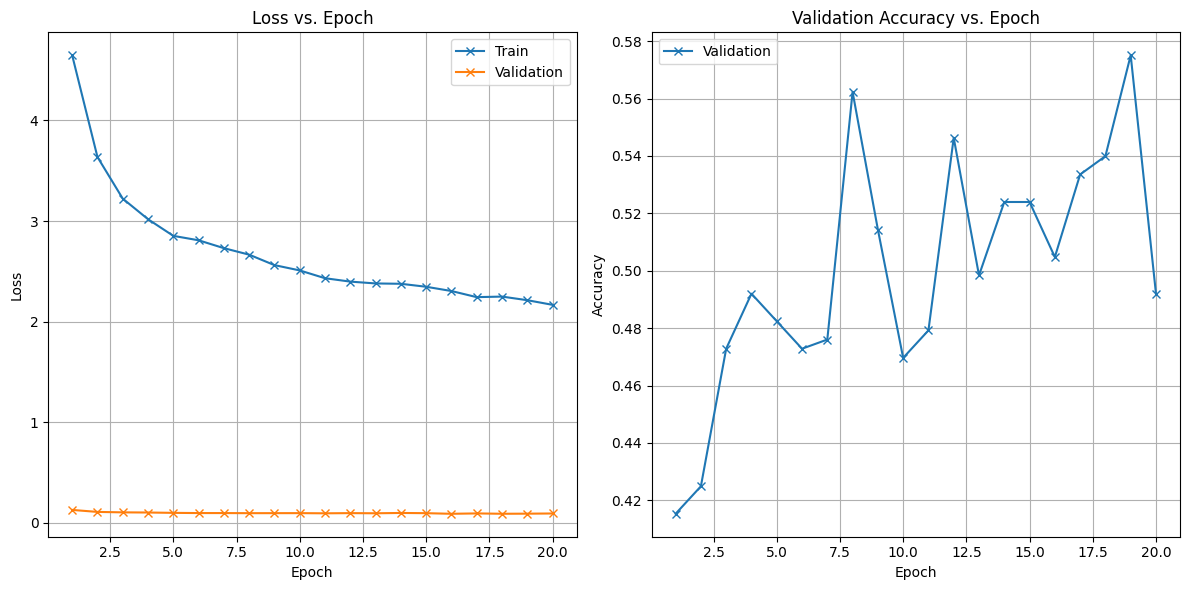

In [58]:

plot_curves(train_history, val_history)

## Proposed model : Mobilenet V2
Using MobilenetV2 model(transfer learning) which performed better on tis dataset with the best parameters observed thoughout this project.

- Learning rate = 0.001 with sheduler for step size 10 and gamma 0.1
- batch_size = 32
- provided image transformation in the baseline
- adam optimizer
- epoch = 50 (used with scheduler to mitigate the chnace of overfitting)

Result:
- Proposed Models Learned paramter: 2417303
- Number of FLOPs: 0.61G
- Validation accuracy =  0.859
-  Testing Accuracy = 94.42


In [27]:
import torch
import torchvision
from efficientnet_pytorch import EfficientNet
from torchvision.models import mobilenet_v2
import os
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from tqdm import tqdm
from FLOPs_counter import print_model_parm_flops

# Set hyperparameters
num_epochs = 50
num_classes = 151
dropout_prob = 0.4




In [28]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print(f"Training data size:{train_size}\n{'='*40}\nTesting data size:{test_size}\n{'='*40}\nValidation data size:{val_size}")

Training data size:5330
Testing data size:627
Validation data size:313


In [29]:
# SETTING DATALOADER FOR EACH SETS OF DATA
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=32, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=32, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=32, pin_memory=True)

# Get the default device
device = get_default_device()

# Move the model and the dataloader to the appropriate device
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

Training proposed model

In [30]:
import torchvision.models as models
num_epochs = 50
# Load the pretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Freeze the parameters of the pre-trained layers
for param in model.features.parameters():
    param.requires_grad = False

# Modify the MobileNetV2 classifier
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, num_classes)
)


# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define your loss function and optimizer here
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model & Validation
print("Training MobileNetV2\n" + "=" * 80)
trainer = ModelTrainer(model, criterion, optimizer, exp_lr_scheduler, device)
trained_model, (train_history, val_history) = trainer.train(train_dl, val_dl, num_epochs)

# Evaluate the model on the test set
trainer.test(test_dl)

Training MobileNetV2
Epoch 0/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.70it/s, Loss=0.0592, Acc=0.789]


Epoch 1/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s, Loss=0.0497, Acc=0.789]


Epoch 2/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s, Loss=0.0449, Acc=0.812]


Epoch 3/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s, Loss=0.0437, Acc=0.831]


Epoch 4/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.72it/s, Loss=0.044, Acc=0.799]


Epoch 5/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s, Loss=0.042, Acc=0.808]


Epoch 6/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.65it/s, Loss=0.0419, Acc=0.824]


Epoch 7/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s, Loss=0.0429, Acc=0.847]


Epoch 8/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.72it/s, Loss=0.0445, Acc=0.815]


Epoch 9/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s, Loss=0.0441, Acc=0.821]


Epoch 10/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s, Loss=0.0421, Acc=0.853]


Epoch 11/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.28it/s, Loss=0.0412, Acc=0.843]


Epoch 12/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.78it/s, Loss=0.0419, Acc=0.843]


Epoch 13/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s, Loss=0.0408, Acc=0.856]


Epoch 14/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.72it/s, Loss=0.0404, Acc=0.827]


Epoch 15/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s, Loss=0.0417, Acc=0.853]


Epoch 16/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s, Loss=0.0412, Acc=0.84]


Epoch 17/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.46it/s, Loss=0.0421, Acc=0.837]


Epoch 18/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s, Loss=0.0415, Acc=0.818]


Epoch 19/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s, Loss=0.0397, Acc=0.863]


Epoch 20/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s, Loss=0.0406, Acc=0.834]


Epoch 21/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s, Loss=0.043, Acc=0.805]


Epoch 22/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s, Loss=0.0417, Acc=0.834]


Epoch 23/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s, Loss=0.0409, Acc=0.837]


Epoch 24/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s, Loss=0.0411, Acc=0.856]


Epoch 25/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.24it/s, Loss=0.0425, Acc=0.824]


Epoch 26/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s, Loss=0.0433, Acc=0.818]


Epoch 27/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s, Loss=0.0422, Acc=0.843]


Epoch 28/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s, Loss=0.0422, Acc=0.815]


Epoch 29/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s, Loss=0.0416, Acc=0.853]


Epoch 30/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s, Loss=0.0403, Acc=0.84]


Epoch 31/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s, Loss=0.0406, Acc=0.831]


Epoch 32/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s, Loss=0.0406, Acc=0.853]


Epoch 33/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s, Loss=0.0419, Acc=0.831]


Epoch 34/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.08it/s, Loss=0.0417, Acc=0.834]


Epoch 35/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s, Loss=0.042, Acc=0.84]


Epoch 36/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.31it/s, Loss=0.0416, Acc=0.856]


Epoch 37/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.43it/s, Loss=0.0401, Acc=0.847]


Epoch 38/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s, Loss=0.0406, Acc=0.85]


Epoch 39/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.31it/s, Loss=0.0408, Acc=0.834]


Epoch 40/49
----------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, Loss=0.0402, Acc=0.875]


Epoch 41/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s, Loss=0.0404, Acc=0.837]


Epoch 42/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s, Loss=0.0406, Acc=0.859]


Epoch 43/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s, Loss=0.042, Acc=0.847]


Epoch 44/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.35it/s, Loss=0.0401, Acc=0.863]


Epoch 45/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, Loss=0.0398, Acc=0.85]


Epoch 46/49
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s, Loss=0.0409, Acc=0.866]


Epoch 47/49
----------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s, Loss=0.0417, Acc=0.853]


Epoch 48/49
----------


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s, Loss=0.0414, Acc=0.805]


Epoch 49/49
----------


Testing: 100%|██████████| 20/20 [00:02<00:00,  7.26it/s, Loss=0.039, Acc=0.943]

Test Loss: 0.0390 Test ACC: 0.9426


Loss vs Epoch and Val_acc vs Epoch curve for final_model

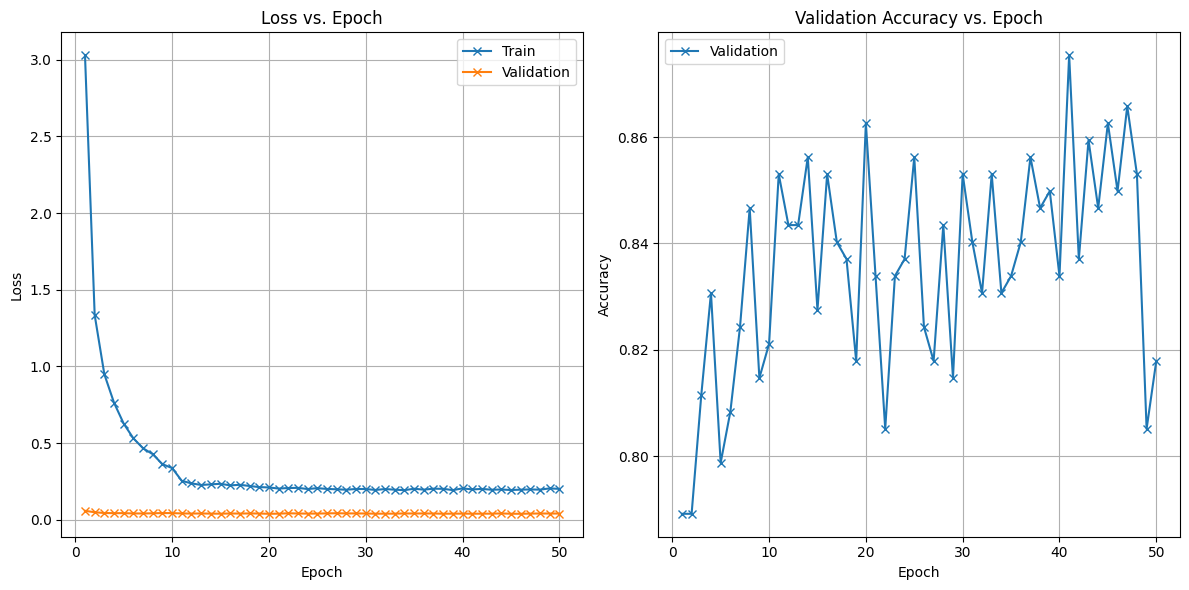

In [33]:
plot_curves(train_history, val_history)

In [34]:
# Learned parameters
input_tensor = torch.randn(32, 3, 224, 224).to(device)  # input tensor
print(f"Proposed Models Learned paramter:",count_model_params(trained_model, input_tensor))

Proposed Models Learned paramter: 2417303


In [35]:
# flop
print_model_parm_flops(trained_model,input_tensor)

 + Number of FLOPs: 0.61G


### **Testing on full Dataset**

In [41]:
# Setting seed so that value won't change every time.
torch.manual_seed(10)

# Dataloader settings
batch_size = 32
num_workers = 32
pin_memory = True

# Create DataLoader for the entire dataset
full_dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# Get the default device
device = get_default_device()

# Move the model and the dataloader to the appropriate device
full_dl = DeviceDataLoader(full_dataset_loader, device)


In [37]:
def topk_accuracy(model, test_loader, device, topk=5):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.topk(outputs, topk, dim=1)  # Get top k predictions
            total += labels.size(0)
            correct += (labels.view(-1, 1) == predicted).sum().item()

    accuracy = correct / total
    print(f"Top-{topk} Accuracy on test data: {accuracy * 100:.2f}%")

In [39]:
topk_accuracy(trained_model, full_dl, device,1)

Top-1 Accuracy on test data: 94.85%


In [40]:
topk_accuracy(trained_model, full_dl, device,3)

Top-3 Accuracy on test data: 97.34%


In [38]:
topk_accuracy(trained_model, full_dl, device)

Top-5 Accuracy on test data: 98.28%
